In [1]:
import sys

PWD = '..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats

In [2]:
dataset = np.load(f'../data/dataset.npz', allow_pickle=True)

In [3]:
all_X, all_y = dataset['X'], dataset['y']

all_X.shape, all_y.shape

((19570, 64), (19570,))

In [45]:
def plot_difference_hist(y_true, y_pred, channel, hist_range=(-2, 2), n_bins=100):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=True)

    plt.title(f'Diff histogram (channel={channel}), mean={mu:0.2f}, std={std:0.2f}')
    plt.show()

# Preprocess

In [5]:
n_baseline = 20

In [6]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

# Utils

In [8]:
def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='test')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"val loss {history[f'val_loss'].values[-1]:0.4f} (min: {min(history[f'val_loss'].values):0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()
    
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')

# CFD

In [46]:
cfd = CFD(fraction=0.23)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(3914,)

In [47]:
mean_squared_error(y_test, y_pred)

1.133668860542164

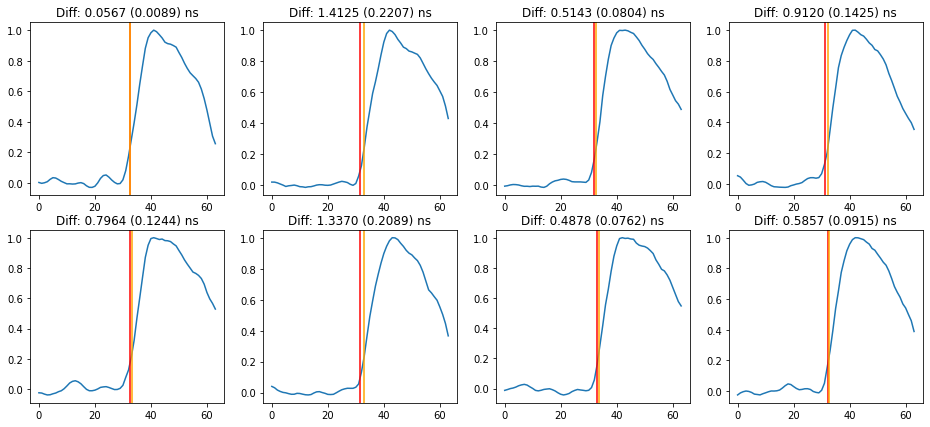

In [48]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

In [49]:
y_pred.shape

(3914,)

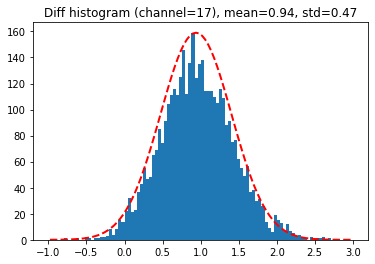

In [52]:
plot_difference_hist(y_test, y_pred, 17, hist_range=(-1, 3))

# Model 1

In [53]:
model = keras.Sequential([
    layers.Input(64),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.1))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=40))

# history = model.fit(X_train, y_train, epochs=2000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# model.save_weights('model_weights/nn_experiments/model_1/weights')
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_1/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_1/weights')
history = pd.read_csv('model_weights/nn_experiments/model_1/loss_log.csv')

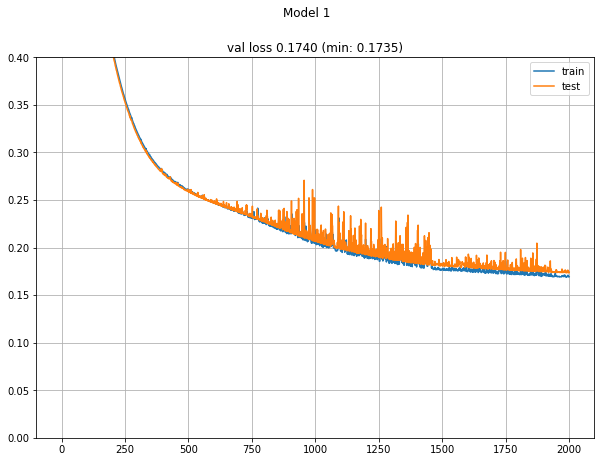

In [54]:
plot_history(history, "Model 1", ymax=0.4)

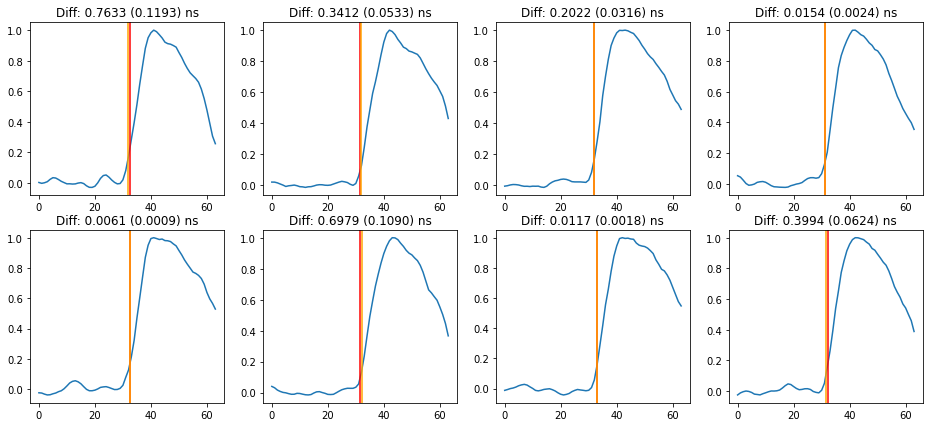

In [55]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

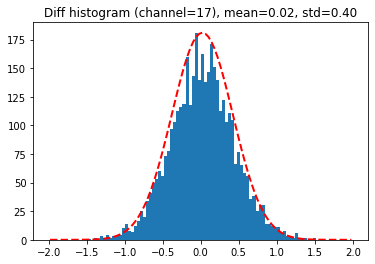

In [56]:
plot_difference_hist(y_test, y_pred, 17)

# Model 2

In [57]:
model = keras.Sequential([
    layers.Input(64),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.01))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50))

# history = model.fit(X_train, y_train, epochs=2000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
# model.save_weights('model_weights/nn_experiments/model_2/weights')
# pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_2/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_2/weights')
history = pd.read_csv('model_weights/nn_experiments/model_2/loss_log.csv')

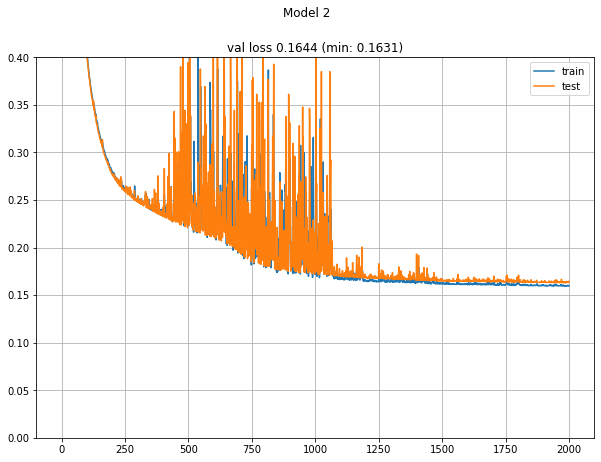

In [58]:
plot_history(history, "Model 2", ymax=0.4)

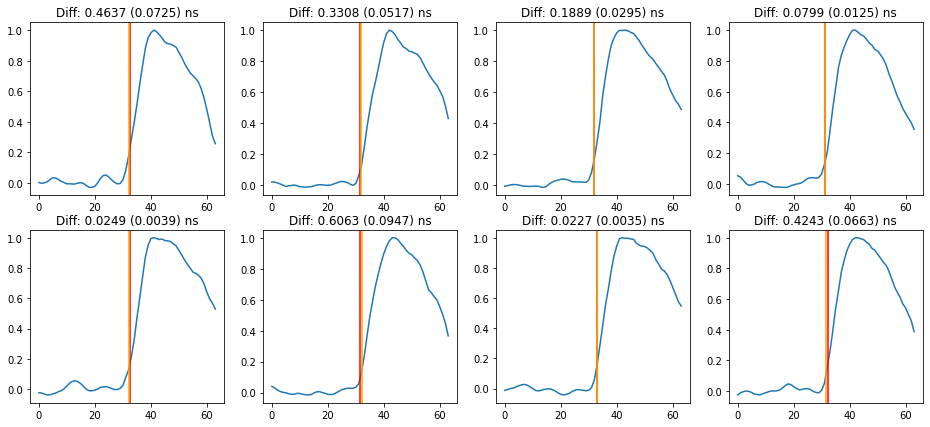

In [59]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

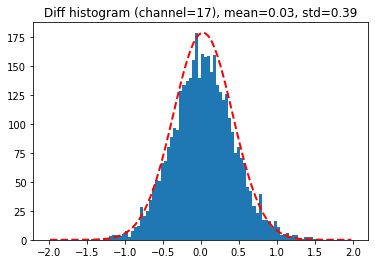

In [60]:
plot_difference_hist(y_test, y_pred, 17)

# Model 3

In [66]:
model = keras.Sequential([
    layers.Input(64),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    # layers.Conv1D(256, 3, padding='same', activation='relu'),
    # layers.BatchNormalization(),
    # layers.Conv1D(256, 3, padding='same', activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=optimizers.Adam(0.01))

model_callbacks = []
model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50))
model_callbacks.append(callbacks.ModelCheckpoint(filepath='model_weights/nn_experiments/model_3/weights', save_best_only=True, save_weights_only=True))

history = model.fit(X_train, y_train, epochs=1000, verbose=1, batch_size=2048, validation_data=(X_test, y_test), callbacks=model_callbacks).history
pd.DataFrame(history).to_csv('model_weights/nn_experiments/model_3/loss_log.csv')

model.load_weights('model_weights/nn_experiments/model_3/weights')
history = pd.read_csv('model_weights/nn_experiments/model_3/loss_log.csv')

Epoch 1/1000
8/8 [==============================] - 2s 121ms/step - loss: 196.8153 - val_loss: 505.5526 - lr: 0.0100
Epoch 2/1000
8/8 [==============================] - 1s 88ms/step - loss: 0.7814 - val_loss: 179.2749 - lr: 0.0100
Epoch 3/1000
8/8 [==============================] - 0s 56ms/step - loss: 0.4350 - val_loss: 183.4393 - lr: 0.0100
Epoch 4/1000
8/8 [==============================] - 0s 56ms/step - loss: 0.3332 - val_loss: 293.0314 - lr: 0.0100
Epoch 5/1000
8/8 [==============================] - 0s 56ms/step - loss: 0.2702 - val_loss: 403.7815 - lr: 0.0100
Epoch 6/1000
8/8 [==============================] - 0s 56ms/step - loss: 0.2376 - val_loss: 507.1203 - lr: 0.0100
Epoch 7/1000
8/8 [==============================] - 0s 57ms/step - loss: 0.2168 - val_loss: 564.0811 - lr: 0.0100
Epoch 8/1000
8/8 [==============================] - 0s 56ms/step - loss: 0.2064 - val_loss: 595.5484 - lr: 0.0100
Epoch 9/1000
8/8 [==============================] - 0s 59ms/step - loss: 0.2019 - val

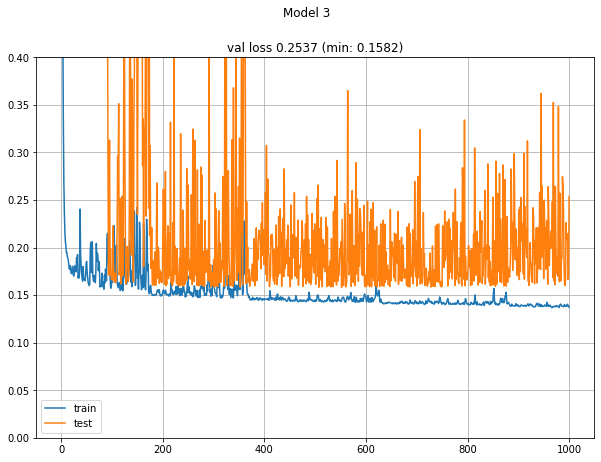

In [67]:
plot_history(history, "Model 3", ymax=0.4)

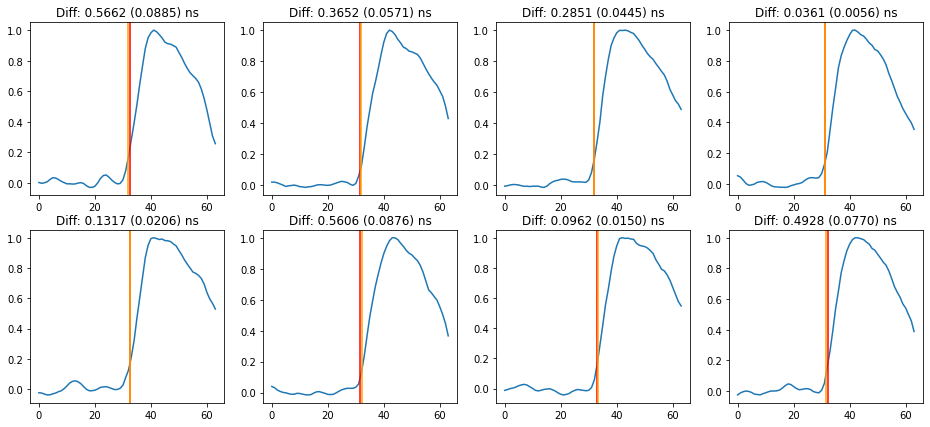

In [68]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

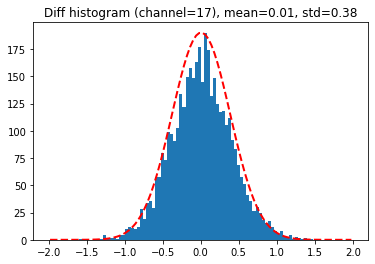

In [69]:
plot_difference_hist(y_test, y_pred, 17)